# Reinforcement Learning Application for CryBot

In [ ]:
#!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 
!pip install --upgrade --no-deps --force-reinstall https://github.com/AminHP/gym-anytrading/archive/master.zip
!pip install stable-baselines3
!pip install gym
clear_output()

In [1]:
"""Assuming the following packages are installed:"""
from IPython.display import clear_output
#!pip install pyarrow
#!pip install fastparquet
#!piip install ta-lib
#!pip install shapely
clear_output()

from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import tree

from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn import model_selection

#
from talib import SMA,MACD,RSI,BBANDS,STOCH

# Gym stuff
import gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C

Text(0.5, 1.0, 'ETH-USDT')

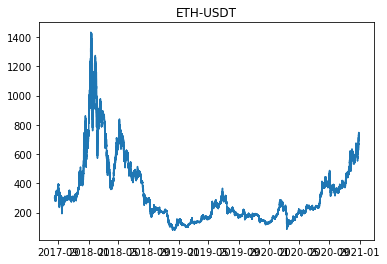

In [26]:
#Read in historical data.
eth  = pq.read_table('ETH-USDT.parquet').to_pandas()

#Assign proper timestamp & indexing.
eth['open_time_epoch'] = pd.to_datetime(eth.index, unit='ms')

#Numerize all data.

eth = eth.apply(pd.to_numeric)

#Plot all DOGE data.
plt.plot(eth.index,eth.close)
plt.title('ETH-USDT')

In [37]:
eth.rename(columns={'open': 'Open', 'high': 'High', 'low':'Low', 'close':'Close', 'volume':'Volume', 'quote_asset_volume':'Quote_asset_volume',
       'number_of_trades':'Number_of_trades', 'taker_buy_base_asset_volume':'Taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume':'Taker_buy_quote_asset_volume', 'open_time_epoch':'Open_time_epoch'}, inplace=True)

In [38]:
env = gym.make('stocks-v0', df=eth, frame_bound=(5,1000), window_size=5)

In [40]:
env.signal_features

array([[301.13      ,   0.        ],
       [301.13      ,   0.        ],
       [300.        ,  -1.1300049 ],
       ...,
       [301.44      ,   0.        ],
       [302.        ,   0.55999756],
       [302.        ,   0.        ]], dtype=float32)

In [41]:
env.action_space

Discrete(2)

info {'total_reward': -18.9300537109375, 'total_profit': 0.028520223416555746, 'position': 1}


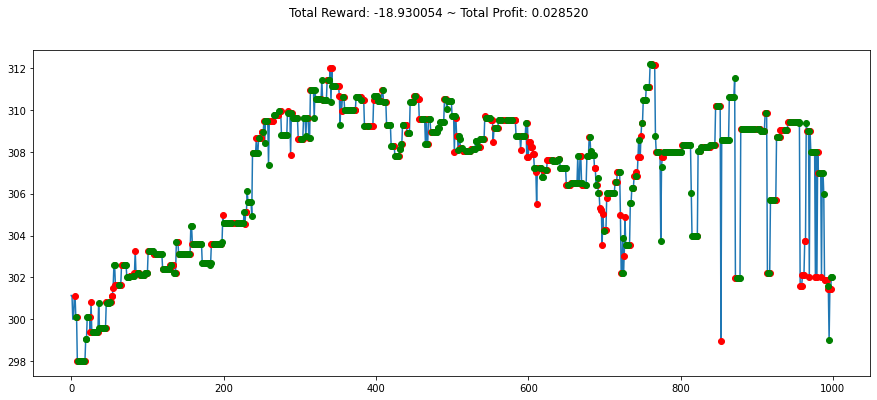

In [42]:
state = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break
        
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

In [44]:
!pip install finta
clear_output()

In [45]:
from gym_anytrading.envs import StocksEnv
from finta import TA

In [49]:
eth['SMA'] = TA.SMA(eth, 12)
eth['RSI'] = TA.RSI(eth)
eth['OBV'] = TA.OBV(eth)
eth.fillna(0, inplace=True)

In [51]:
#Create new env's
df = eth
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [52]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [55]:
env2.signal_features

array([[ 3.01130005e+02,  4.26429987e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.01130005e+02,  2.75786996e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+02,  9.92999971e-02,  0.00000000e+00,
         0.00000000e+00, -9.92999971e-02],
       [ 3.00000000e+02,  3.13890010e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.01130005e+02,  2.32020006e-01,  0.00000000e+00,
         5.36986301e+01,  1.32720008e-01],
       [ 3.00000000e+02,  7.57049978e-01,  0.00000000e+00,
         5.36986301e+01,  0.00000000e+00],
       [ 3.00100006e+02,  9.00179982e-01,  0.00000000e+00,
         3.42539837e+01, -7.67459974e-01],
       [ 3.00100006e+02,  0.00000000e+00,  0.00000000e+00,
         3.42539837e+01,  0.00000000e+00],
       [ 2.98000000e+02,  3.14929992e-01,  0.00000000e+00,
         1.84535309e+01, -1.08238997e+00],
       [ 2.98000000e+02,  0.00000000e+00,  0.00000000e+00,
         1.84535309e+01

In [57]:
#Build environment & train
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [72]:
model = A2C('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 169      |
|    ep_rew_mean        | 2.27     |
| time/                 |          |
|    fps                | 489      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.679   |
|    explained_variance | 0.336    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.186    |
|    value_loss         | 0.122    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 169      |
|    ep_rew_mean        | 3.46     |
| time/                 |          |
|    fps                | 474      |
|    iterations         | 200      |
|    time_elapsed 

In [73]:
#Evaluation
env = MyCustomEnv(df=df, window_size=12, frame_bound=(80,250))
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break

info {'total_reward': 1.3599853515625, 'total_profit': 0.6392446800614755, 'position': 0}


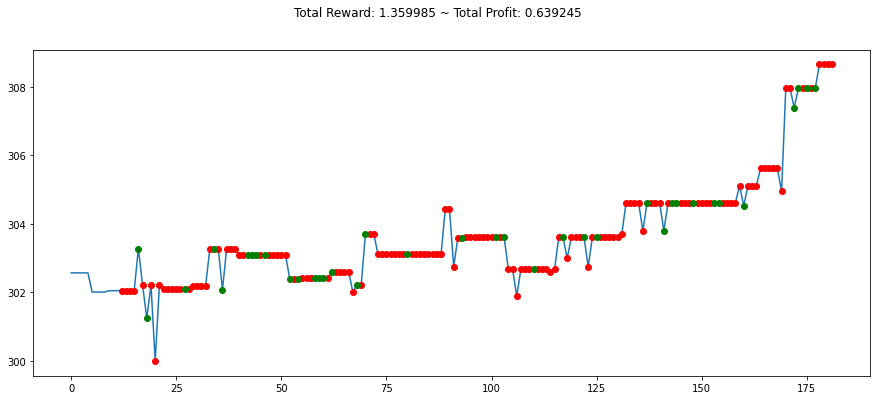

In [74]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()